<a href="https://colab.research.google.com/github/rodolfoarruda/MachineLearning/blob/main/recom_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rodolfo Arruda - 6381848

### **SCC5966 – Sistemas de Recomendação**

## **Setup**

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [194]:
import pandas as pd
import matplotlib.pyplot as plt

# calculate sparsity
from numpy import array
from numpy import count_nonzero

# calculo de similaridade
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

## **1 - Data Preparation**

In [160]:
df = pd.read_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/train_data.csv',sep=',')
df.head()

,user_id,movie_id,rating,timestamp
0,1,1160,5,974769817
1,1,1129,3,974769817
2,1,3328,4,974769817
3,1,2659,2,974769817
4,1,980,3,974769817


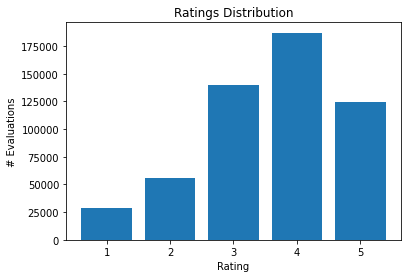

In [161]:
plt.bar(df['rating'].value_counts().index,df['rating'].value_counts())
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('# Evaluations');

#### **1.1 - Data Normalization**

In [173]:
def sub_mean(df):
  ## Normalize rating by movie
  avg_movie = pd.DataFrame(df['rating'].groupby(df['movie_id']).mean())
  avg_movie = avg_movie.rename(columns = {'rating': 'avg_movie'})
  avg_movie.reset_index(inplace=True)
  result1 = pd.merge(df, avg_movie, on="movie_id")
  result1['rating_avgr_movie'] = result1['rating'] - result1['avg_movie']

  ## Normalize rating by user
  avg_user= pd.DataFrame(df['rating'].groupby(df['user_id']).mean())
  avg_user = avg_user.rename(columns = {'rating': 'avg_user'})
  avg_user.reset_index(inplace=True)
  result2 = pd.merge(result1, avg_user, on="user_id")
  result2['rating_avgr_user'] = result2['rating'] - result2['avg_user']

  return result2

In [174]:
df_norm = sub_mean(df)

In [175]:
df_norm.head()

,user_id,movie_id,rating,timestamp,avg_movie,rating_avgr_movie,avg_user,rating_avgr_user
0,1,1160,5,974769817,3.937198,1.062802,3.769231,1.230769
1,1,1129,3,974769817,3.993320,-0.993320,3.769231,-0.769231
2,1,3328,4,974769817,3.662202,0.337798,3.769231,0.230769
3,1,2659,2,974769817,3.688333,-1.688333,3.769231,-1.769231
4,1,980,3,974769817,3.927287,-0.927287,3.769231,-0.769231


#### **1.2 - Dummy submission - by average movie**

In [243]:
avg_movie = pd.DataFrame(df['rating'].groupby(df['movie_id']).mean())
avg_movie.reset_index(inplace=True)

In [244]:
avg_movie.head()

,movie_id,rating
0,1,4.142373
1,2,3.214854
2,3,3.040000
3,4,2.666667
4,5,3.079137


In [245]:
df_test = pd.read_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/test_data.csv',sep=',')
df_test.head()

,id,user_id,movie_id,timestamp
0,0,5,2962,974769784
1,1,5,3177,974769768
2,2,5,3153,974769768
3,3,5,501,974769768
4,4,5,3159,974769768


In [246]:
df_test.count()

id           3970
user_id      3970
movie_id     3970
timestamp    3970
dtype: int64

In [247]:
pred_dummy_movie = pd.merge(df_test, avg_movie, on="movie_id",how="left").fillna(4)

In [248]:
pred_dummy_movie.head()

,id,user_id,movie_id,timestamp,rating
0,0,5,2962,974769784,3.388000
1,1,5,3177,974769768,3.245223
2,2,5,3153,974769768,2.742857
3,3,5,501,974769768,3.615079
4,4,5,3159,974769768,2.987013


In [251]:
pred = pred_dummy_movie[['id','rating']]
pred.head()

,id,rating
0,0,3.388000
1,1,3.245223
2,2,2.742857
3,3,3.615079
4,4,2.987013


In [252]:
pred.to_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/s1.csv',index=False)

#### **1.3 - Dummy submission - by average user**

In [253]:
  avg_user= pd.DataFrame(df['rating'].groupby(df['user_id']).mean())
  avg_user.reset_index(inplace=True)

In [254]:
avg_user.head()

,user_id,rating
0,1,3.769231
1,2,3.428571
2,3,3.818182
3,4,4.375000
4,5,3.637931


In [257]:
pred_dummy_user = pd.merge(df_test, avg_user, on="user_id",how="left").fillna(4)

In [258]:
pred_dummy_user.count()

id           3970
user_id      3970
movie_id     3970
timestamp    3970
rating       3970
dtype: int64

In [259]:
pred = pred_dummy_user[['id','rating']]
pred.head()

,id,rating
0,0,3.637931
1,1,3.637931
2,2,3.637931
3,3,3.637931
4,4,3.637931


In [260]:
pred.to_csv('/content/drive/MyDrive/Doutorado/disciplinas/recom_sys/scc5966/s2.csv',index=False)

## **2 - Claborative Filtering based on movie**


#### **2.1 - user x item matrix**


In [176]:
A = df_norm.pivot(index='user_id', columns='movie_id', values='rating_avgr_movie').fillna(0)

In [177]:
A

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3525,3526,3527,3528,3529,3530,3531,3532,3533,3534,3535,3536,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546,3547,3548,3549,3550,3551,3552,3553,3554,3555,3556,3557,3558,3559,3560,3561,3562,3563,3564
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.889023,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.804554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.714286,1.666667,0.069231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.700758,0.6,0.0,0.0,0.135135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


#### **2.2 - Sparcity evaluation**
##### The sparsity of a matrix can be quantified with a score, which is the number of zero values in the matrix divided by the total number of elements in the matrix.

In [178]:
sparsity = 1.0 - count_nonzero(A) /A.size
print(sparsity)

0.9620829658314144


##### A dense matrix stored in a NumPy array can be converted into a sparse matrix using the CSR representation by calling the csr_matrix() function.

In [179]:
from scipy import sparse

In [180]:
train = sparse.csr_matrix((df_norm.rating_avgr_movie, (df_norm.user_id, df_norm.movie_id)))

In [181]:
print(train)

  (1, 32)	-0.8890229191797347
  (1, 108)	0.7855113636363633
  (1, 249)	0.5091879075281565
  (1, 324)	-1.5584415584415585
  (1, 518)	0.6955665024630546
  (1, 561)	-0.07477243172951908
  (1, 683)	0.5386631716906942
  (1, 821)	-0.08499475341028351
  (1, 980)	-0.9272869429241597
  (1, 1067)	0.8892171344165432
  (1, 1075)	0.8360797918473546
  (1, 1099)	0.8316412859560067
  (1, 1112)	0.8741935483870966
  (1, 1129)	-0.9933199732798932
  (1, 1160)	1.0628019323671496
  (1, 1266)	-0.0242424242424244
  (1, 1531)	-0.7902542372881354
  (1, 1552)	0.8914728682170541
  (1, 2201)	-2.123839009287926
  (1, 2226)	1.1192052980132452
  (1, 2286)	0.6584192439862546
  (1, 2659)	-1.6883333333333335
  (1, 2677)	-1.6727642276422765
  (1, 2723)	-1.2777777777777777
  (1, 3116)	-0.025990099009900902
  :	:
  (3973, 3367)	-0.04411764705882337
  (3973, 3374)	0.03536977491961402
  (3973, 3405)	-0.07692307692307665
  (3973, 3440)	-0.044303797468354666
  (3974, 39)	-0.6097240473061762
  (3974, 358)	0.26016260162601634
  

#### **2.3 - Compute similar movies**


In [ ]:
def compute_movie_similarity_count(sparse_matrix, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)

    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    
    
    return no_of_similar_movies

In [201]:
similarity = cosine_similarity(train.T, dense_output = False)

In [213]:
similar_movies = cosine_similarity(train[:,32].T, train.T).ravel()

In [214]:
similar_movies_indices = np.argsort(-similar_movies)[1:]

In [215]:
similar_movies_indices

array([  47, 1060, 2587, ..., 2043, 2478,  595])

#### **2.3 - Similarity Matrix**

##### A similarity matrix is critical to measure and calculate the similarity between user-profiles and movies to generate recommendations. To remove movie and user bias, we need to re-escale ratings base on average. 

## **References**

##### https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

##### https://pub.towardsai.net/recommendation-system-in-depth-tutorial-with-python-for-netflix-using-collaborative-filtering-533ff8a0e444